# ABS Retail Turnover 8501

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-the-ABS" data-toc-modified-id="Get-data-from-the-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from the ABS</a></span></li><li><span><a href="#Plot---retail-turnover-by-industry" data-toc-modified-id="Plot---retail-turnover-by-industry-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot - retail turnover by industry</a></span><ul class="toc-item"><li><span><a href="#Plotting-initialisation-/-constants" data-toc-modified-id="Plotting-initialisation-/-constants-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plotting initialisation / constants</a></span></li><li><span><a href="#Data-extraction-and-plotting-functions" data-toc-modified-id="Data-extraction-and-plotting-functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data extraction and plotting functions</a></span></li><li><span><a href="#Main-plotting-loop" data-toc-modified-id="Main-plotting-loop-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Main plotting loop</a></span></li></ul></li><li><span><a href="#Plot---retail-turnover-by-state" data-toc-modified-id="Plot---retail-turnover-by-state-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot - retail turnover by state</a></span></li><li><span><a href="#Finished" data-toc-modified-id="Finished-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib
import calendar
from typing import Tuple, Optional, List, Dict

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    find_id,
    recalibrate_series,
    clear_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('fivethirtyeight')

## Get data from the ABS

In [2]:
# get ABS retail data
retail_catalogue_id = '8501'
source, CHART_DIR, META_DATA = get_fs_constants(retail_catalogue_id)
retail_dict = get_ABS_meta_and_data(retail_catalogue_id)
if retail_dict is None:
    sys.exit(-1)
retail_meta = retail_dict[META_DATA]

# get ABS inflation data
cpi_catalogue_id = '6401'
cpi_dict = get_ABS_meta_and_data(cpi_catalogue_id)
if cpi_dict is None:
    sys.exit(-1)
cpi_meta = cpi_dict[META_DATA]


Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


In [3]:
if False:
    display(retail_meta)

## Plot - retail turnover by industry

### Plotting initialisation / constants

In [4]:
# clear the old charts
clear_chart_dir(CHART_DIR)

# --- Globals ---- Note: this use of globals
#                  is a bit ugly and should 
#                  be refactored

# multi-line the title if might be too long.
LONG_LABEL = 30 # characters

table_col = 'Table'
did_col = 'Data Item Description'
type_col = 'Series Type'

FROM_DATE = pd.Period('2017-01-01', freq='M')
LIN_REGRESS = pd.Period('2020-01-01', freq='M')

retail_type = 'Seasonally Adjusted'

### Data extraction and plotting functions

In [5]:
def get_retail_series(retail_label: str,
    ) -> Tuple[pd.Series, str]:
    
    id_selector = {
        retail_table: table_col,
        retail_label: did_col,
        retail_type: type_col,
    }
    retail_series_id, retail_units = find_id(retail_meta, id_selector)
    retail_series, retail_units = (
        recalibrate_series(retail_df[retail_series_id], retail_units)
    )
    retail_series.index = pd.PeriodIndex(retail_series.index, freq='M')
    retail_series = retail_series[retail_series.index >= FROM_DATE]

    return retail_series, retail_units

In [6]:
def plot_retail_series(retail_series: pd.Series, 
                       retail_units:str, 
                       title: str
    ) -> None:
    
    ax = retail_series.plot(lw=2, c='#0000dd')

    lfooter = f'{retail_type}. Current prices. '
    finalise_plot(
        ax, 
        title, 
        f'{retail_units}',
        '', # tag
        CHART_DIR,
        rfooter=f'{source} {retail_table}',
        lfooter=lfooter,
        #show=True,
    )    

In [7]:
def get_cpi_series(cpi_label: str,
                   retail_series:pd.Series,
    ) -> pd.Series:
    
    id_selector = {
        cpi_table: table_col,
        cpi_label: did_col,
        'Index Numbers': did_col,
    }
    cpi_series_id, cpi_units = find_id(cpi_meta, id_selector, )
    cpi_series = cpi_df[cpi_series_id] / 100 # rebase index to 1
    cpi_series = cpi_series / cpi_series.iloc[-1] # rebase to latest period
    cpi_series.index = pd.PeriodIndex(cpi_series.index, freq='Q')
    cpi_series = cpi_series.resample('M').interpolate(method='linear', pad=None)
    
    # TO DO: augment CPI monthly series when not aligned with Retail Traide

    cpi_series = cpi_series[cpi_series.index >= FROM_DATE]
    
    return cpi_series

In [8]:
def get_retail_projection(adj_retail_series: pd.Series) -> pd.Series:
    
    y = adj_retail_series[adj_retail_series.index <= LIN_REGRESS]
    x = np.arange(len(y))
    regress_data = pd.DataFrame({
        'y': y.values,
        'x': x,
    })
    model = smf.ols(formula='y ~ x', data=regress_data).fit()
    #print(model.summary())
    print(model.params)

    xx = np.arange(len(adj_retail_series))
    projection = (
        pd.Series(xx * model.params['x'] + model.params['Intercept'],
                  index = adj_retail_series.index)
    )
    
    return projection

In [9]:
def plot_CPI_adjusted(adj_retail_series: pd.Series,
                      retail_units: str,
                      projection: pd.Series,
                      title: str,
                      cpi_label: str,
    ) -> None:
    
    ax2 = adj_retail_series.plot(lw=2, c='blue', label='Retail Turnover (CPI Adj)')
    projection.plot(lw=2, c='darkorange', ax=ax2, ls='--', label='Pre-COVID projection')
    ax2.legend(loc='best')
    lfooter = (
        f'Seas Adj. CPI price adjust: {cpi_label}. '
        f'Projection on period from {FROM_DATE} to {LIN_REGRESS}'
    )
    finalise_plot(
        ax2, 
        title, 
        f'{retail_units} CPI Adjusted', 
        '-CPI-adjusted', # tag
        CHART_DIR,
        rfooter=f'{source} {retail_table} {cpi_catalogue_id} {cpi_table}',
        lfooter=lfooter,
        show=True,
    )    

### Main plotting loop

Intercept    12.404877
x             0.017941
dtype: float64


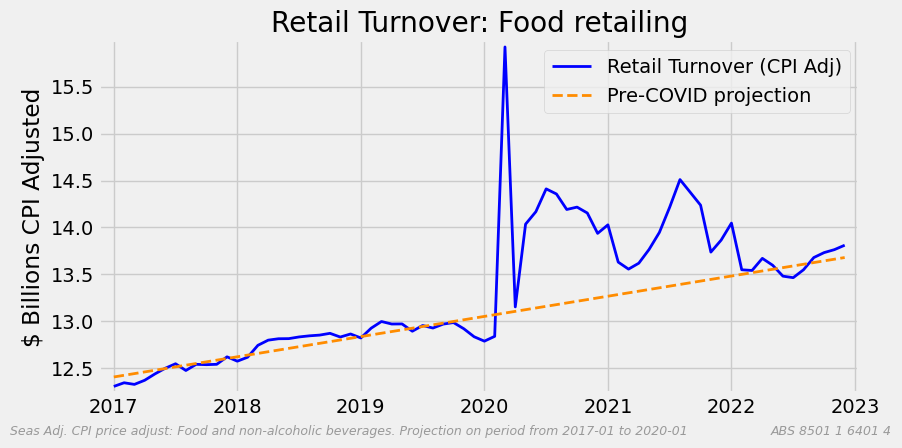

Intercept    5.253448
x            0.004793
dtype: float64


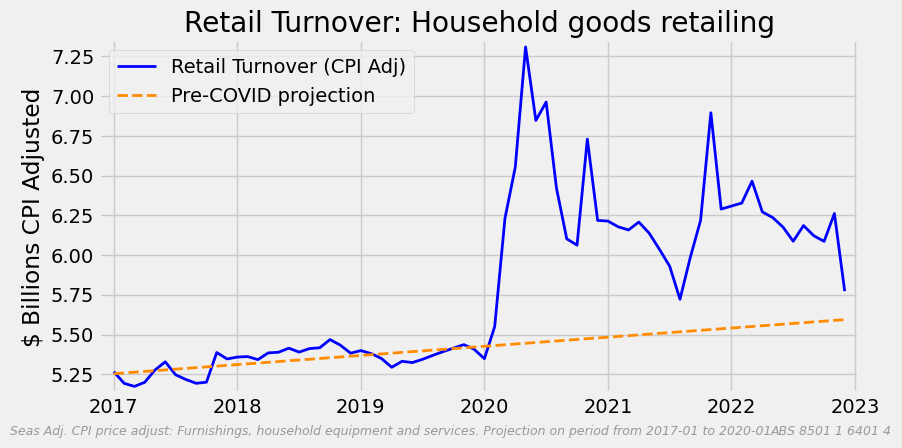

Intercept    2.067256
x            0.006622
dtype: float64


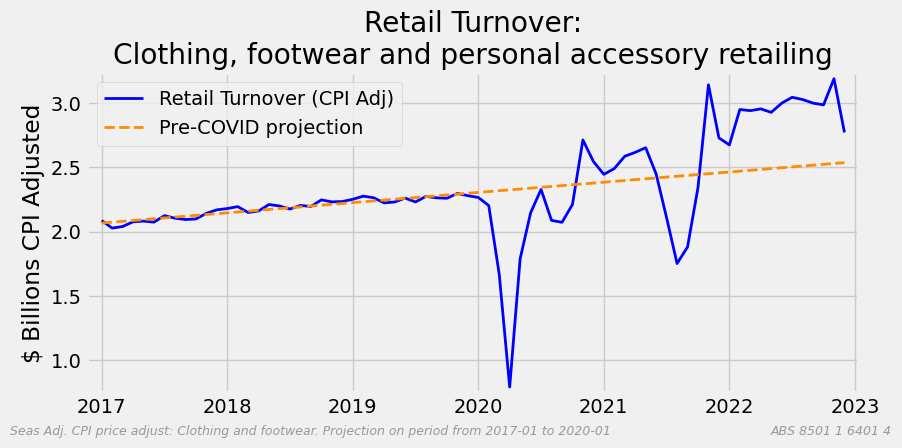

Intercept    1.831779
x           -0.001950
dtype: float64


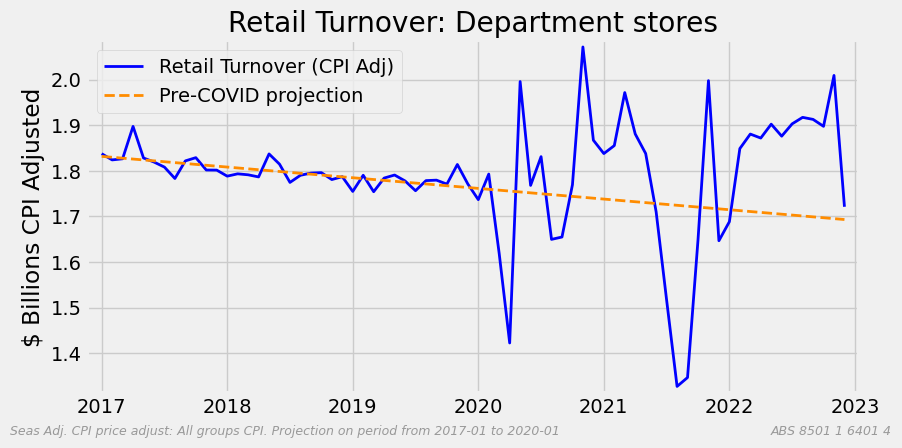

Intercept    4.324715
x            0.005011
dtype: float64


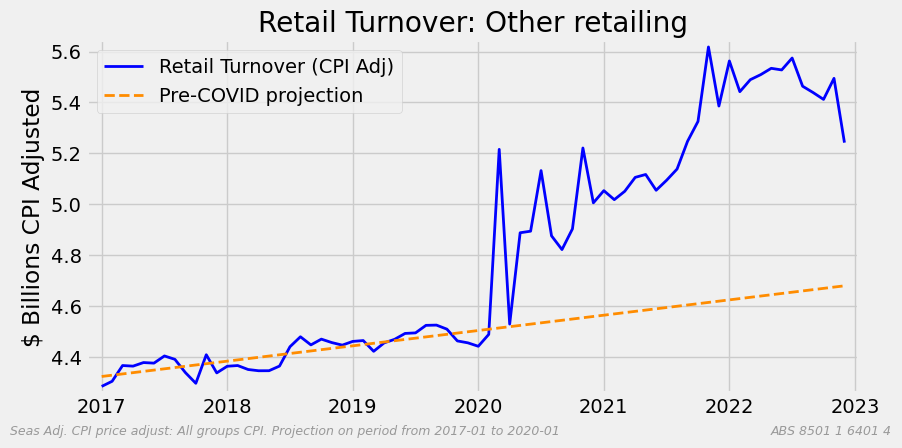

Intercept    4.311185
x            0.003700
dtype: float64


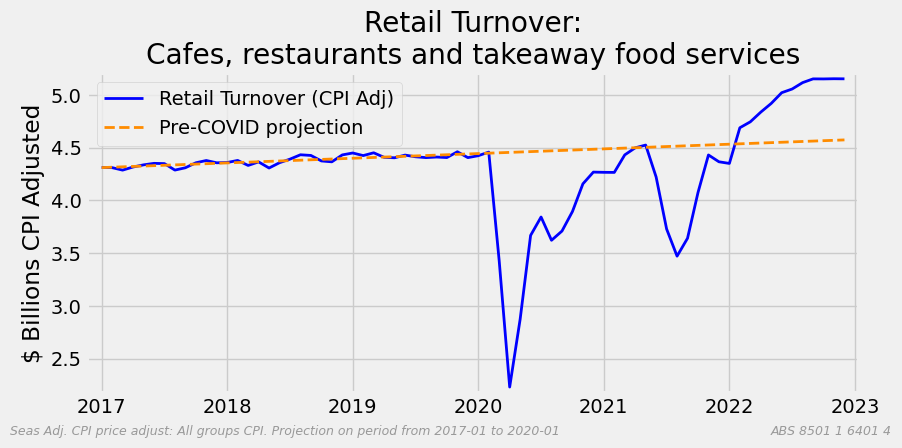

Intercept    30.369823
x             0.025605
dtype: float64


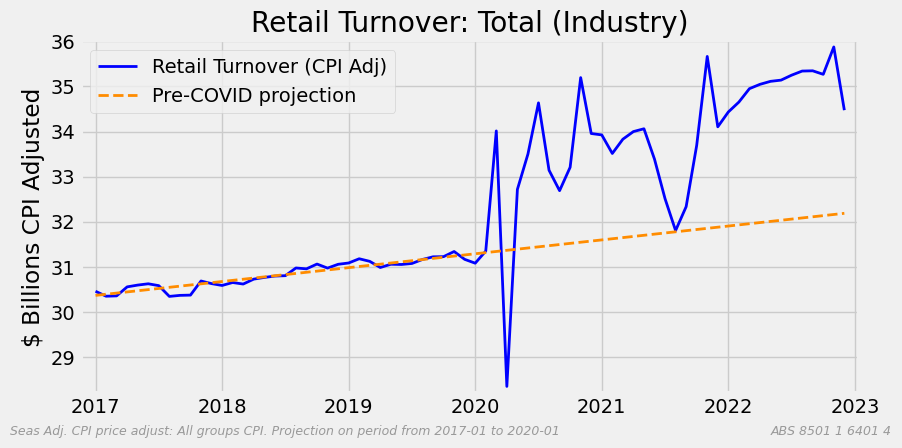

In [10]:
# --- frame --- this is a bit ugly, as some of these names
#               are accessed by the above functions
#               from the global environment. Which is
#               why we have them in the same cell as the 
#               plotting loop

industry_map = {
    # retail turnover: cpi index,
    'Food retailing': 'Food and non-alcoholic beverages',
    'Household goods retailing': 'Furnishings, household equipment and services',
    'Clothing, footwear and personal accessory retailing': 'Clothing and footwear',
    'Department stores': 'All groups CPI', 
    'Other retailing': 'All groups CPI',
    'Cafes, restaurants and takeaway food services': 'All groups CPI',
    'Total (Industry)': 'All groups CPI',
}

retail_table = '1'
retail_df = retail_dict[retail_table]

cpi_table = '4'
cpi_df = cpi_dict[cpi_table]


# --- plotting loop ---
for retail_label, cpi_label in industry_map.items():
    
    retail_series, retail_units = get_retail_series(retail_label)

    separator = '\n' if len(retail_label) > LONG_LABEL else ' '
    title = f'Retail Turnover:{separator}{retail_label}'
    plot_retail_series(retail_series, retail_units, title)
    
    cpi_series = get_cpi_series(cpi_label, retail_series)
    adj_retail_series = retail_series / cpi_series
    
    projection = get_retail_projection(adj_retail_series)
    
    plot_CPI_adjusted(adj_retail_series, retail_units,
                      projection, title, cpi_label)


## Plot - retail turnover by state

Intercept    9.781932
x            0.001959
dtype: float64
10.336681942117497


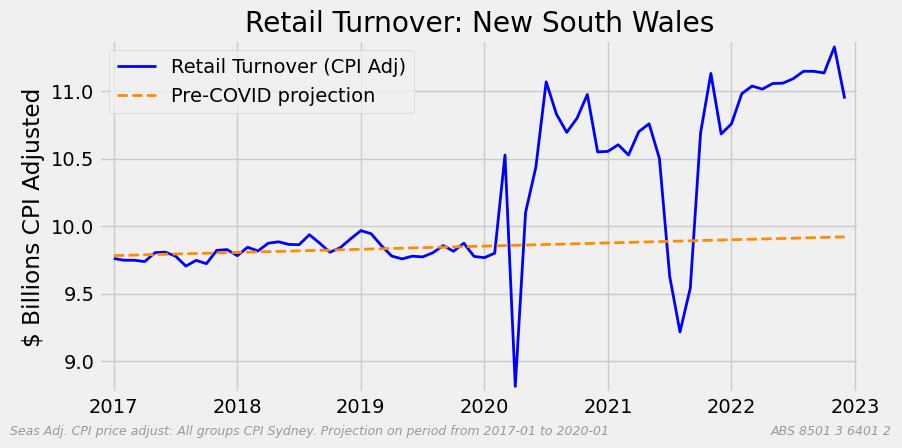

Intercept    7.693258
x            0.014714
dtype: float64
0.6073718745529533


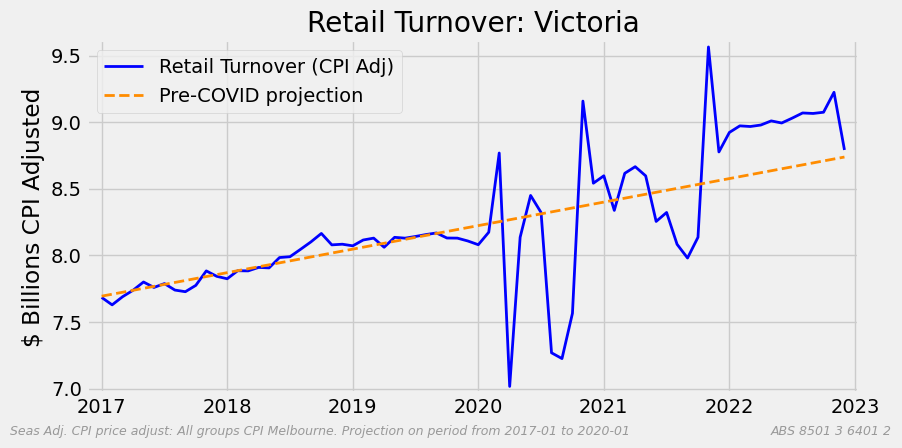

Intercept    6.058566
x            0.008769
dtype: float64
6.535113026333228


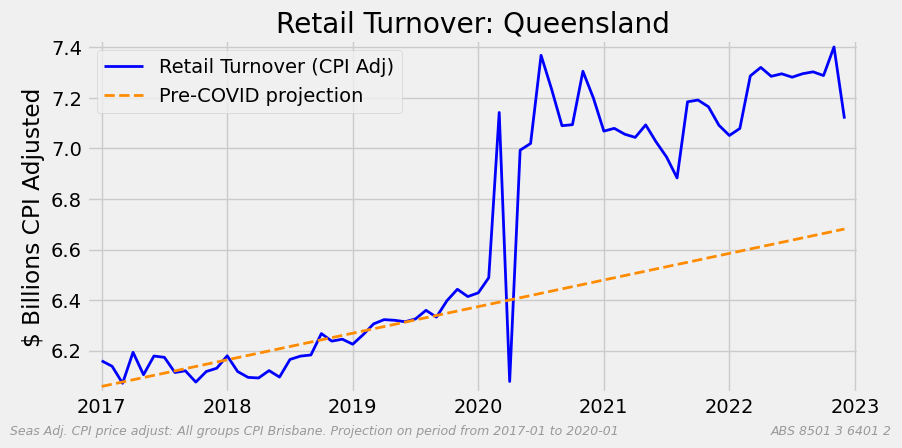

Intercept    2.028803
x            0.000487
dtype: float64
6.853808009103712


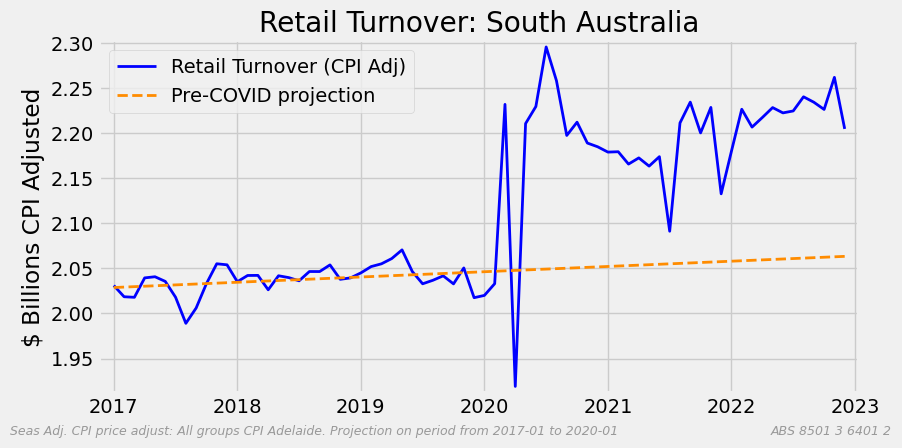

Intercept    3.346870
x           -0.001134
dtype: float64
15.73201173369343


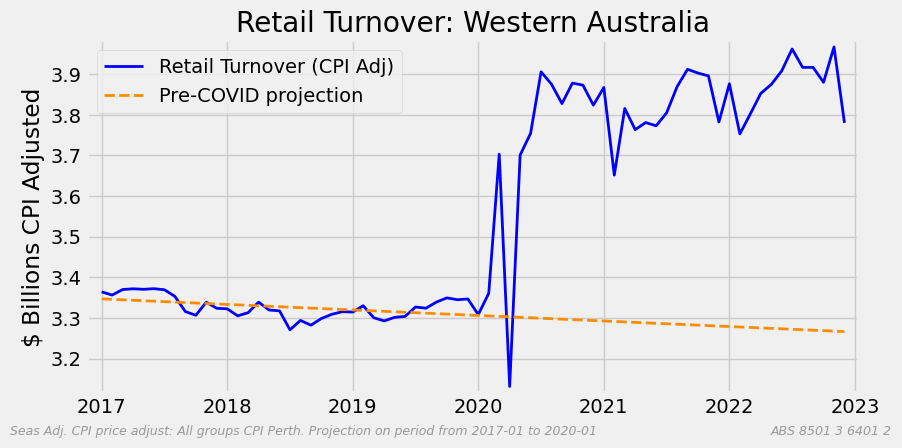

Intercept    621.252009
x              0.698998
dtype: float64
2.4921202903620543


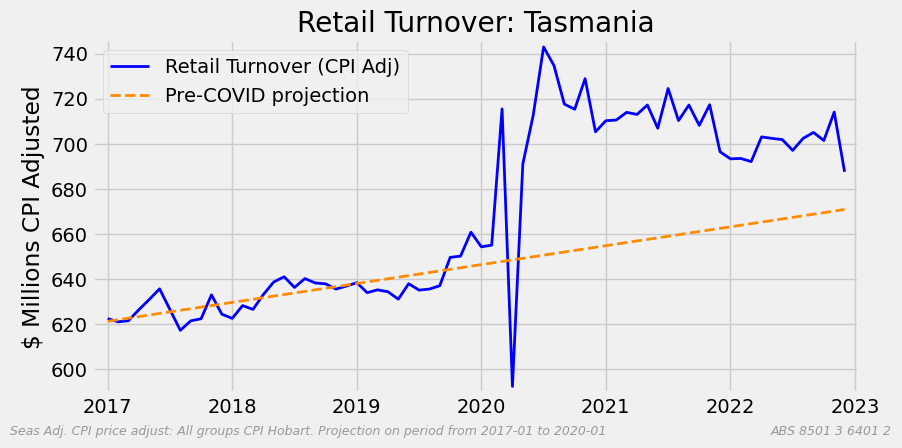

Intercept    304.528443
x             -0.291217
dtype: float64
9.106130836900661


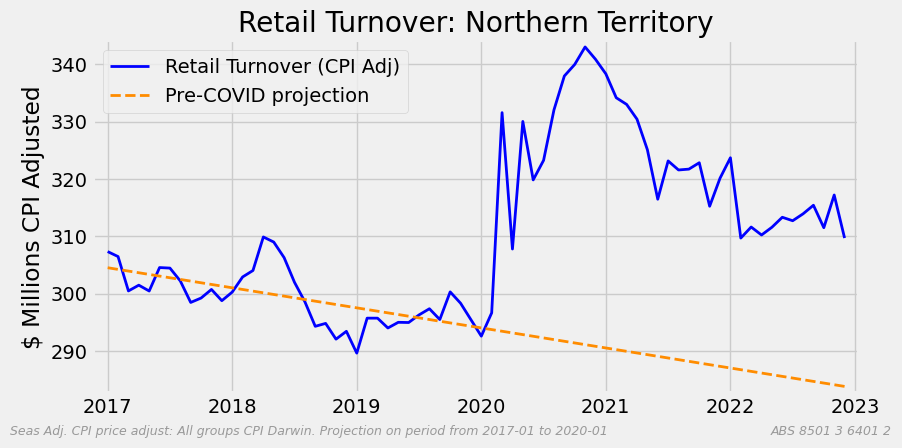

Intercept    561.700642
x              0.539077
dtype: float64
5.80438930178353


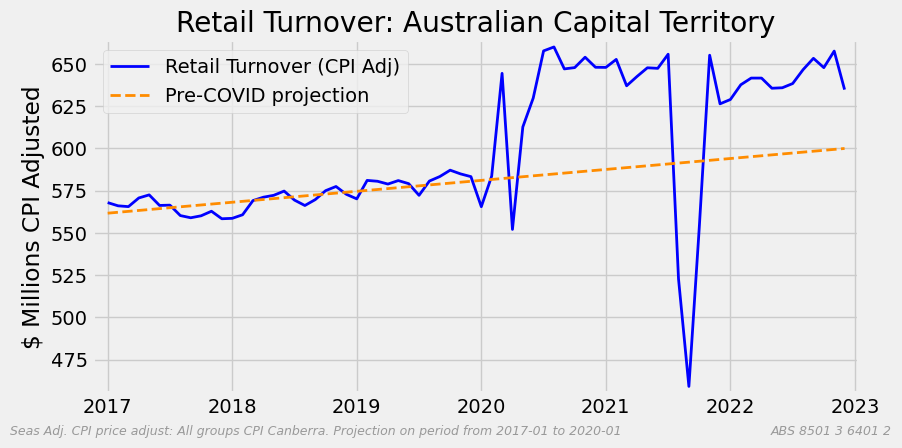

In [11]:
# --- Note: --- Quite a bit of code duplication in this cell 
#               from the previous cell. It should be refactored 
#               at some point.

# -- initialisation
state_map = {
    'New South Wales': 'Sydney',
    'Victoria': 'Melbourne',
    'Queensland': 'Brisbane',
    'South Australia': 'Adelaide',
    'Western Australia': 'Perth',
    'Tasmania': 'Hobart',
    'Northern Territory': 'Darwin',
    'Australian Capital Territory': 'Canberra',
}

retail_table = '3'
retail_df = retail_dict[retail_table]

cpi_table = '2'
cpi_df = cpi_dict[cpi_table]


# -- plotting loop
for state_label, city_label in state_map.items():
    
    state_series, state_units = get_retail_series(state_label)
    
    separator = '\n' if len(state_label) > LONG_LABEL else ' '
    title = f'Retail Turnover:{separator}{state_label}'
    plot_retail_series(state_series, state_units, title)
    
    # Index Numbers ;  All groups CPI ;  Sydney ;
    cpi_label = f'All groups CPI ;  {city_label}'
    cpi_series = get_cpi_series(cpi_label, state_series)

    adj_state_series = state_series / cpi_series    
    projection = get_retail_projection(adj_state_series)
    
    print( ((adj_state_series.iloc[-1] / projection.iloc[-1]) - 1) * 100 )

    plot_CPI_adjusted(adj_state_series, state_units,
                      projection, title, 
                      cpi_label.replace(';  ', ''))


## Finished

In [12]:
print('Finished')

Finished
